In [ ]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install sympy

In [2]:
import sympy as sym
from sympy import symbols, Function, Eq, solve, I, collect, expand, simplify,\
                  Derivative, init_printing, series, evaluate
init_printing()

In [3]:
x1, x2 = symbols("x1 x2",real=True)
y1, y2 = symbols("y1 y2",real=True)
eps = symbols("varepsilon",real=True)
eq = [Eq(y1,x2),Eq(y2,-x1-eps*x1**5)]
# словарь ключ левая часть, значения правая часть уравнения
subs_eq={eq[0].lhs:eq[0].rhs, eq[1].lhs:eq[1].rhs}
eq

C:\Users\User\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\User\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\User\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\User\anaconda3\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The MathtextBacken

In [4]:
# Делаем замену z - комплексная переменная, комплексно сопряженная
z, zs = symbols("z zs",complex=True)
Subs_cmplx = [Eq(x1,z+zs),Eq(x2,I*(z-zs))]

Subs_cmplx_dict=dict(zip([eq.lhs for eq in Subs_cmplx],[eq.rhs for eq in Subs_cmplx]))
# получаем выражения для z и zs
Sol_cmplx=solve(Subs_cmplx,[z,zs])

# Подставляем в исходное уравнение
eq1=collect(expand(Sol_cmplx[z].subs({x1:y1,x2:y2}).subs(subs_eq)),eps)
eqz=eq1.subs(Subs_cmplx_dict).simplify().expand()

Subs_conjz={I:-I,zs:z,z:zs}
eqz,eqz.subs(Subs_conjz,simultaneous=True)

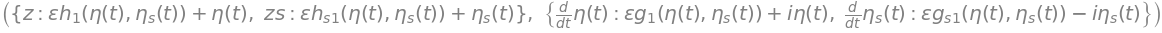

In [5]:
## Произведем разложение до 1 порядка
Nexp=1
Nrng=range(1,Nexp+1)

t=symbols("t",real=True)
eta=Function("eta",real=True)(t)
ceta=Function("eta_s",real=True)(t)

h_lst =[1]+[Function(f'h{i}',real=True)(eta,ceta) for i in Nrng]
ch_lst=[1]+[Function(f'h_s{i}',real=True)(eta,ceta) for i in Nrng]
g_lst =[1]+[Function(f'g{i}')(eta,ceta) for i in Nrng]
cg_lst=[1]+[Function(f'g_s{i}')(eta,ceta) for i in Nrng]

Subs_z={z:eta+sum([eps**i*h_lst[i] for i in Nrng]),\
        zs:ceta+sum([eps**i*ch_lst[i] for i in Nrng])}
        
Subs_Deta={Derivative(eta,t):I*eta+sum([eps**i*g_lst[i] for i in Nrng]),\
           Derivative(ceta,t):-I*ceta+sum([eps**i*cg_lst[i] for i in Nrng])}

Subs_conjeta={I:-I,eta:ceta,ceta:eta}
Subs_z,Subs_Deta

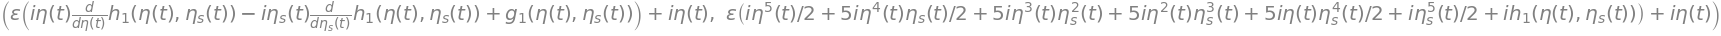

In [6]:
# Вычисляем правую и левую часть уравнения
LHS=series(Subs_z[z].diff(t).subs(Subs_Deta),eps,0,Nexp+1).removeO()
RHS=series(eqz.subs(Subs_z),eps,0,Nexp+1).removeO()
LHS,RHS

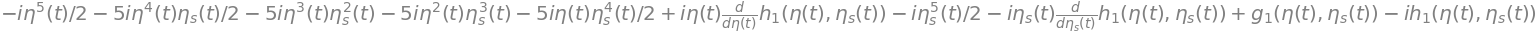

In [9]:
# Гомологическое уравнение 1 порядка
HomEq1=(LHS-RHS).coeff(eps,1)
HomEq1

In [10]:
def MkHomogForm(ord,coefname,vars):
    """
    Construct homogeneous form of order n from vars
    """
    global coef_lst
    coef_lst=[symbols(f'{coefname}{i}{ord-i}') for i in range(ord+1)]
    form=sum([coef_lst[i]*vars[0]**i*vars[1]**(ord-i) for i in range(ord+1)])
    return coef_lst,form

def GetCoeffHomEq(homeq,ord,vars):
    """
    Get coefficients from the homological equation which correspond to 
    homogeneous monomials of order ord in of vaiables vars
    """
    return [homeq.coeff(vars[0]**i*vars[1]**(ord-i)) for i in range(ord+1)]

In [11]:
# Рассматриваем h_i в виде однородной формы 3 степени
alpha1_lst,h1subs = MkHomogForm(3,'alpha1',[eta,ceta])
Subs_h={h_lst[1]:h1subs}
Subs_h.update({ch_lst[1]:Subs_h[h_lst[1]].subs(Subs_conjeta,simultaneous=True)})
Subs_h

In [12]:
# Подставляем в гомологическую форму h_1
SubsHomEq1=collect((HomEq1.subs(Subs_h)).doit().expand(),[eta,ceta],exact=True).expand()
SubsHomEq1

In [13]:
# Получаем коэффиценты гомологического уравнения
h1_lst=GetCoeffHomEq(SubsHomEq1,3,[eta,ceta])

# Находим эти коэффиценты решая уравнение
Subs_alph1=solve(h1_lst,alpha1_lst)

Eq_g1=SubsHomEq1.subs(Subs_alph1).simplify()
Subs_alph1, solve(Eq_g1,g_lst[1],dict=True)

In [14]:
Subs_alph1.update({alpha1_lst[2]:0})
Subs_alph1

In [15]:
# Вычиляем h1 и g1
for h in Subs_h.keys():
    Subs_h[h]=Subs_h[h].subs(Subs_alph1, simultaneous=True)
Subs_g=solve(Eq_g1,g_lst[1],dict=True)[0]#dict()
Subs_g.update({cg_lst[1]:Subs_g[g_lst[1]].subs(Subs_conjeta,simultaneous=True)})
Subs_h,Subs_g

In [16]:
# Получаем нормальную форму
NF_eta=Subs_Deta[Derivative(eta,t)].subs(Subs_g)
NF_eta

In [17]:
# Получаемы 1 поправки в частоте
from sympy import exp
rho=Function('rho',real=True)(t)
phi=Function('varphi',real=True)(t)
Subs_polar={eta:rho*exp(I*phi),ceta:rho*exp(-I*phi)}
(NF_eta/(eta)).subs(Subs_polar).expand()

In [18]:
NF_eta.subs(Subs_polar)